# Lecture 11 Demo: CNNs

This demo is adapted from [this Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

## Training a CNN

Now you might be thinking,

### What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Training an image classifier
----------------------------

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

## 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import utils as utils

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.


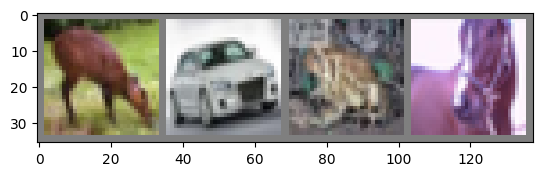

deer  car   frog  horse


In [3]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
utils.imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
images.shape

torch.Size([4, 3, 32, 32])

## 2. Define a Convolutional Neural Network


We're modifying LeNet5 in only one main way:
- Originally it had only one channel, but CIFAR is color, so we have three channels.

We could think about making a number of very simple changes that would probably improve the performance (play around with these on your own!):
- Use BatchNorm after the convolutions.
- Use ReLU rather than Tanh activation functions.
- Use MaxPool rather than AvgPool.

To make sure you get the number of dimensions right, just test it out. For example, to make sure I understand the dimensionality of the data output from `LeNet5.layer1`, I can just run:

In [5]:
test_layer = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size = 2, stride = 2)
)
test_layer(images).shape

torch.Size([4, 6, 14, 14])

In [6]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0), # in: 3 x 32 x 32; out: 6 x 28 x 28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2)) # in: 6 x 28 x 28; out: 6 x 14 x 14
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), # in: 6 x 14 x 14; out: 16 x 10 x 10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2)) # in: 16 x 10 x 10; out: 16 x 5 x 5
        self.fc = nn.Linear(16 * 5 * 5, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

net = LeNet5(num_classes = 10)
net

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

## 3. Define a Loss function and optimizer

Let\'s use a Classification Cross-Entropy loss and Adam as our optimizer.


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

## 4. Train the network

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [8]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.918
[1,  4000] loss: 1.737
[1,  6000] loss: 1.641
[1,  8000] loss: 1.589
[1, 10000] loss: 1.523
[1, 12000] loss: 1.524
[2,  2000] loss: 1.440
[2,  4000] loss: 1.446
[2,  6000] loss: 1.411
[2,  8000] loss: 1.391
[2, 10000] loss: 1.392
[2, 12000] loss: 1.368
[3,  2000] loss: 1.329
[3,  4000] loss: 1.318
[3,  6000] loss: 1.295
[3,  8000] loss: 1.274
[3, 10000] loss: 1.313
[3, 12000] loss: 1.307
[4,  2000] loss: 1.235
[4,  4000] loss: 1.241
[4,  6000] loss: 1.244
[4,  8000] loss: 1.246
[4, 10000] loss: 1.224
[4, 12000] loss: 1.250
[5,  2000] loss: 1.164
[5,  4000] loss: 1.167
[5,  6000] loss: 1.178
[5,  8000] loss: 1.181
[5, 10000] loss: 1.218
[5, 12000] loss: 1.188
Finished Training


Let\'s quickly save our trained model:


In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

## 5. Test the network on the test data

We have trained the network for a few passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


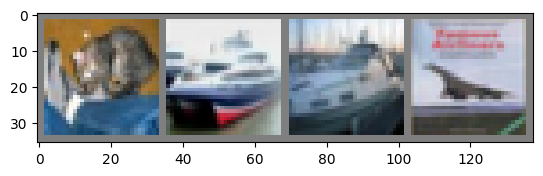

Ground Truth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
utils.imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [11]:
net = LeNet5(num_classes = 10)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [12]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  car   ship 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

confusion_matrix = torch.zeros(len(classes), len(classes))

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            confusion_matrix[prediction, label] += 1
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.6 %
Accuracy for class: car   is 67.1 %
Accuracy for class: bird  is 34.5 %
Accuracy for class: cat   is 36.8 %
Accuracy for class: deer  is 41.4 %
Accuracy for class: dog   is 51.9 %
Accuracy for class: frog  is 65.3 %
Accuracy for class: horse is 65.5 %
Accuracy for class: ship  is 66.8 %
Accuracy for class: truck is 63.8 %


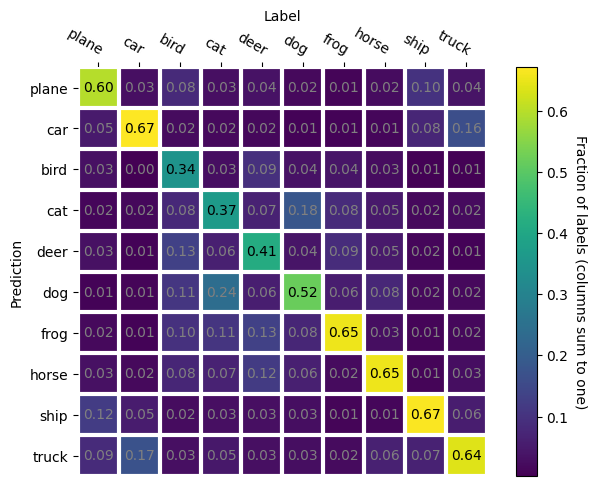

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im, cbar = utils.heatmap(confusion_matrix / confusion_matrix.sum(0, keepdim=True), classes, classes, ax=ax,
                   cmap="viridis", cbarlabel="Fraction of labels (columns sum to one)")
texts = utils.annotate_heatmap(im, valfmt="{x:.2f}", textcolors = ("grey", "black"), threshold = 0.3)

fig.tight_layout()
plt.xlabel("Label")
ax.xaxis.set_label_position('top') 
plt.ylabel("Prediction")
plt.show()

We can look at this to see the kinds of errors our model is making. Cars and trucks are hard to distinguish, as are dogs and cats. Makes sense!